# Quantum Impurity Relaxometry

Magnons are quanta of spin waves, which are modes of collectively precessing spins. Thermally excited magnons in thin magnetic films generate stray fields at the film surface which can be detected using quantum impurities such as nitrogen-vacancy (NV) centers. NVs are lattice defects in diamond and are able to couple with magnon stray fields. Assuming a thermal occupancy of magnon modes, we study the magnetization dynamics of the magnons propagating through thin magnetic insulators using the Landau-Lifshitz-Gilbert equation. We implement a numerical model to predict and understand the response of the NV center to proximal magnons in thin films. We investigate how the NV relaxation rate changes for different NV orientations by extending and generalizing the existing theory on chiral magnetic noise, and simulate an experimental setup for an NV placed just above the surface of an ultrathin magnetic insulator. The simulation includes a static bias field in an arbitrary orientation with respect to the quantization axis of the NV center using the diamond’s tetrahedral symmetry. This extended model is in demand due to limitations in present-day measurement techniques to align the bias field with an NV center. The code in this module is based on and an extension of the QIR theory presented in Rustagi et al. (2020) [1].

## Install the `qir` package

In [2]:
%pip install qir
%pip install matplotlib==3.1.3

## Import required modules

Import the quantum impurity (QI) relaxometry module.

In [3]:
from qir import RelaxationRate, ZFS, GAMMA

Import supporting modules.

In [4]:
import os
import numpy as np
from numpy import pi, linspace, empty_like
import matplotlib.pyplot as plt
import matplotlib.colors as colors

Choose plot style, for instance `seaborn-poster`. For other styles, print `plt.style.available`.

In [5]:
plt.style.use("seaborn")

## Call `RelaxationRate` class

Choose parameters and call the relaxation rate.

In [6]:
B_ext = 31e-3
Gamma = RelaxationRate(bext=B_ext,  
                       quadrants="all", 
                       zoom_in_heatmap=1.5,
                       film_thickness=235e-9)

Check the input arguments.

In [7]:
Gamma.init_locals

{'A_exchange': 3.7e-12,
 'Gilbert_damping': 0.0001,
 'M_saturation': 142000.0,
 'bext': 0.031,
 'dir_nv': [1, 1, 1],
 'distance_nv': 1.09e-07,
 'film_thickness': 2.35e-07,
 'omega': None,
 'phi_nv': 0.0,
 'plusmin': -1,
 'quadrants': 'all',
 'self': <qir.RelaxationRate at 0x7f27118e4350>,
 'temperature': 299,
 'theta_bext': 0.9546951008408984,
 'zoom_in_heatmap': 1.5}

Get kx, ky meshgrids. Create integrand meshgrid corresponding to kx and ky:

- If creating high-res 2D meshgrid plots, use at least `x_pixels = 500` and `y_pixels = 500`.
- If calculating rate $\Gamma$ vs field $B_{ext}$, use `x_pixels = 200` and `y_pixels = 6000`.

In [8]:
Gamma.create_k_bounds()
Gamma.create_k_meshgrids(x_pixels=1000, y_pixels=1000)
Gamma.calculate_sum_di_dj_cij()
Gamma.create_integrand_grid_exclude_nv_distance()
Gamma.create_integrand_grid_include_nv_distance()

Get $k_x$, $k_y$ and $\Gamma$ integrand.

In [9]:
X = Gamma.kx * 1e-6 / (2*pi)  # 2D numpy array [1/um]
Y = Gamma.ky * 1e-6 / (2*pi)  # 2D numpy array [1/um]
Z = Gamma.integrand_grid_include_nv_distance  # 2D numpy array [rad Hz]

Calculate minimum and maximum element in $\Gamma$ integrand array.

In [10]:
vmin = np.amin(Z)
vmax = np.amax(Z)

vmin, vmax

(1.2562860455226863e-14, 0.002401388242713942)

## Plot: $\Gamma_\text{int}$ as function of $k_x$, $k_y$ in normal scale

Plot 2D heatmap of the relaxation rate integrand $\Gamma_\text{int}$ as function of wave number components $k_x$ and $k_y$ using `pyplot.pcolormesh` in normal scale.

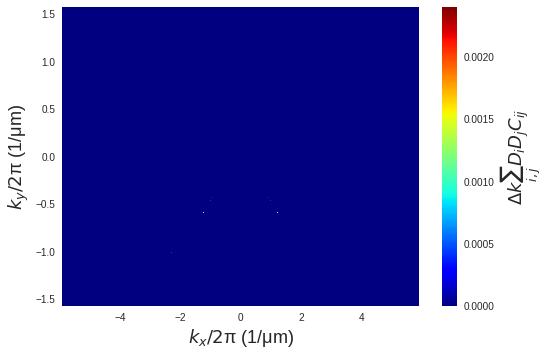

In [11]:
fig0, ax0 = plt.subplots()

# set plot labels
ax0.set_xlabel(r"$k_x/2\mathregular{\pi}$ (1/$\mathregular{\mu}$m)", fontsize=18)
ax0.set_ylabel(r"$k_y/2\mathregular{\pi}$ (1/$\mathregular{\mu}$m)", fontsize=18)

# save pcolormesh
im0 = ax0.pcolormesh(X, Y, Z, cmap='jet', shading="auto")

# set colorbar
cbar0 = fig0.colorbar(im0)
cbar0.set_label(r"$\Delta k \sum_{i,j} D_i D_j C_{ij}$", fontsize=18)

## Plot: $\Gamma_\text{int}$ as function of $k_x$, $k_y$ in logarithmic scale

Plot 2D heatmap of the relaxation rate integrand $\Gamma_\text{int}$ as function of wave number components $k_x$ and $k_y$ using `pyplot.pcolormesh` in $\log_{10}$ scale.

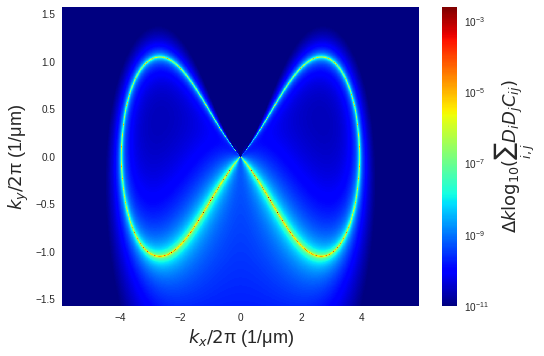

In [12]:
fig1, ax1 = plt.subplots()

# set plot labels
ax1.set_xlabel(r"$k_x/2\mathregular{\pi}$ (1/$\mathregular{\mu}$m)", fontsize=18)
ax1.set_ylabel(r"$k_y/2\mathregular{\pi}$ (1/$\mathregular{\mu}$m)", fontsize=18)

# save pcolormesh
im1 = ax1.pcolormesh(X, Y, Z, cmap='jet', norm=colors.LogNorm(vmin=1e-11, vmax=vmax), shading="auto")

# set colorbar
cbar1 = fig1.colorbar(im1)
cbar1.set_label(r"$\Delta k \log_{10}(\sum_{i,j} D_i D_j C_{ij})$", fontsize=18)

## Plot: $\Gamma$ as function of $B$

Calculate relaxation rate `Gamma` as function of external magnetic field `B`.

In [13]:
def get_rate_vs_field():
    x = linspace(1e-3, 50e-3, 25)
    y = empty_like(x)
    for i in range(len(x)):
        rate = RelaxationRate(A_exchange=8.47e-12, 
                              distance_nv=40e-9, 
                              Gilbert_damping=50e-3,
                              film_thickness=40e-9,
                              M_saturation=324000,
                              bext=x[i])
        rate.kx_min = -5e6 * 2*pi
        rate.kx_max = 5e6 * 2*pi
        rate.ky_min = -2e6 * 2*pi
        rate.ky_max = 2e6 * 2*pi
        rate.create_k_meshgrids(x_pixels=50, y_pixels=4000)
        rate.calculate_sum_di_dj_cij()
        rate.create_integrand_grid_exclude_nv_distance()
        rate.create_integrand_grid_include_nv_distance()
        y[i] = rate.rate_in_MHz
    return x, y

Calculate magnetic field `B` and `rate`.

In [15]:
B, rate = get_rate_vs_field()

Plot the relaxation rate $\Gamma (B)$.

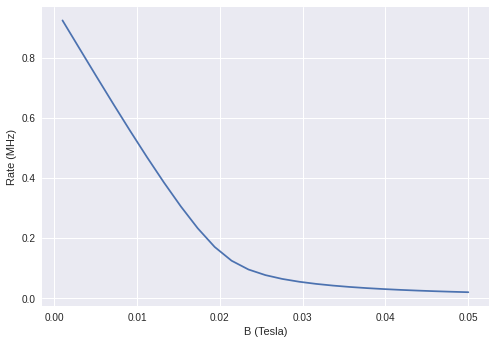

In [16]:
plt.plot(B, rate)
plt.xlabel("B (Tesla)")
plt.ylabel("Rate (MHz)")
plt.show()

## QI distance dependency

Calculate relaxation rate $\Gamma$ as function of distance $d$ between the QI and the magnetic film.

In [17]:
def get_rate_vs_distance(B = 25e-3):
    x = np.geomspace(50e-9, 500e-9, 100)
    y = np.empty_like(x)
    rate = RelaxationRate(bext=B)
    rate.create_k_bounds()
    rate.create_k_meshgrids(x_pixels=100, y_pixels=4000)
    rate.calculate_sum_di_dj_cij()
    rate.create_integrand_grid_exclude_nv_distance()
    for i in range(len(x)):
        rate.distance_nv = x[i]
        rate.create_integrand_grid_include_nv_distance()
        y[i] = rate.rate_in_MHz
    return x, y

Plot the rate $\Gamma (d)$.

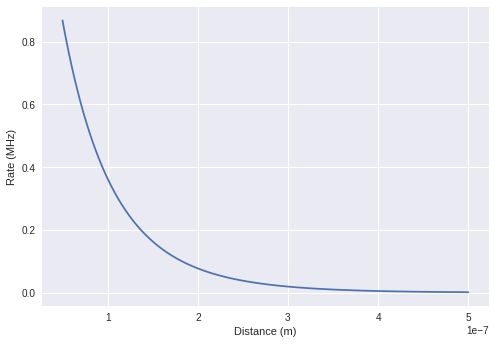

In [18]:
d, r = get_rate_vs_distance()

plt.plot(d, r)
plt.xlabel("Distance (m)")
plt.ylabel("Rate (MHz)")
plt.show()

## Spin-Wave Dispersions

Calculate relaxation rate for film thickness 235 nm.

In [19]:
Gamma1 = RelaxationRate(film_thickness=235e-9)

Generate array for relevant wave numbers.

In [20]:
k = np.linspace(0, 8e6 * 2 * pi, 10000)

Calculate frequencies $\omega$ for:
- Backward-Volume Spin Waves (BVSWs) i.e. $k_y=0$,
- Damon-Eshbach Spin Waves (DESWs) i.e. $k_x=0$.

In [21]:
# BVSW (ky=0)
Gamma1.kx = k
Gamma1.ky = np.zeros_like(k)
Gamma1.create_w_meshgrids()
omega_bvsw = Gamma1.omega_spin_wave_dispersion()

# DESW (kx=0)
Gamma1.ky = k
Gamma1.kx = np.zeros_like(k)
Gamma1.create_w_meshgrids()
omega_desw = Gamma1.omega_spin_wave_dispersion()

Plot dispersion for BVSWs and DESWs.

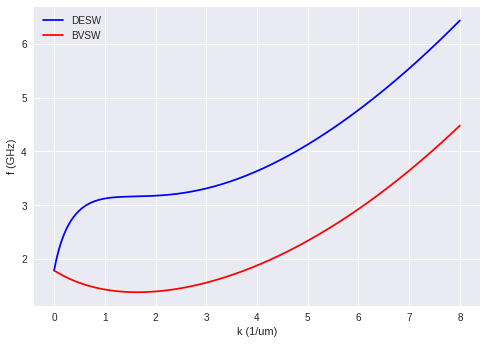

In [22]:
plt.plot(k*1e-6/(2*pi), omega_desw*1e-9/(2*pi), label="DESW", c='b')
plt.plot(k*1e-6/(2*pi), omega_bvsw*1e-9/(2*pi), label="BVSW", c='r')
plt.xlabel("k (1/um)")
plt.ylabel("f (GHz)")
plt.legend()
plt.show()